## HYD 142 Final Project

Team B: Kenneth Larrieu, Catherine Truong, Charles Polc

### a. Plot the data sets, find their histograms, and find the first four moments and coefficient of variation

In [1]:
# Python 3.7
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_az = pd.read_excel('data_project_19.xlsx', sheet_name='PARIA RIVER, AZ')
df_or = pd.read_excel('data_project_19.xlsx', sheet_name='JOHN DAY RIVER, OR')

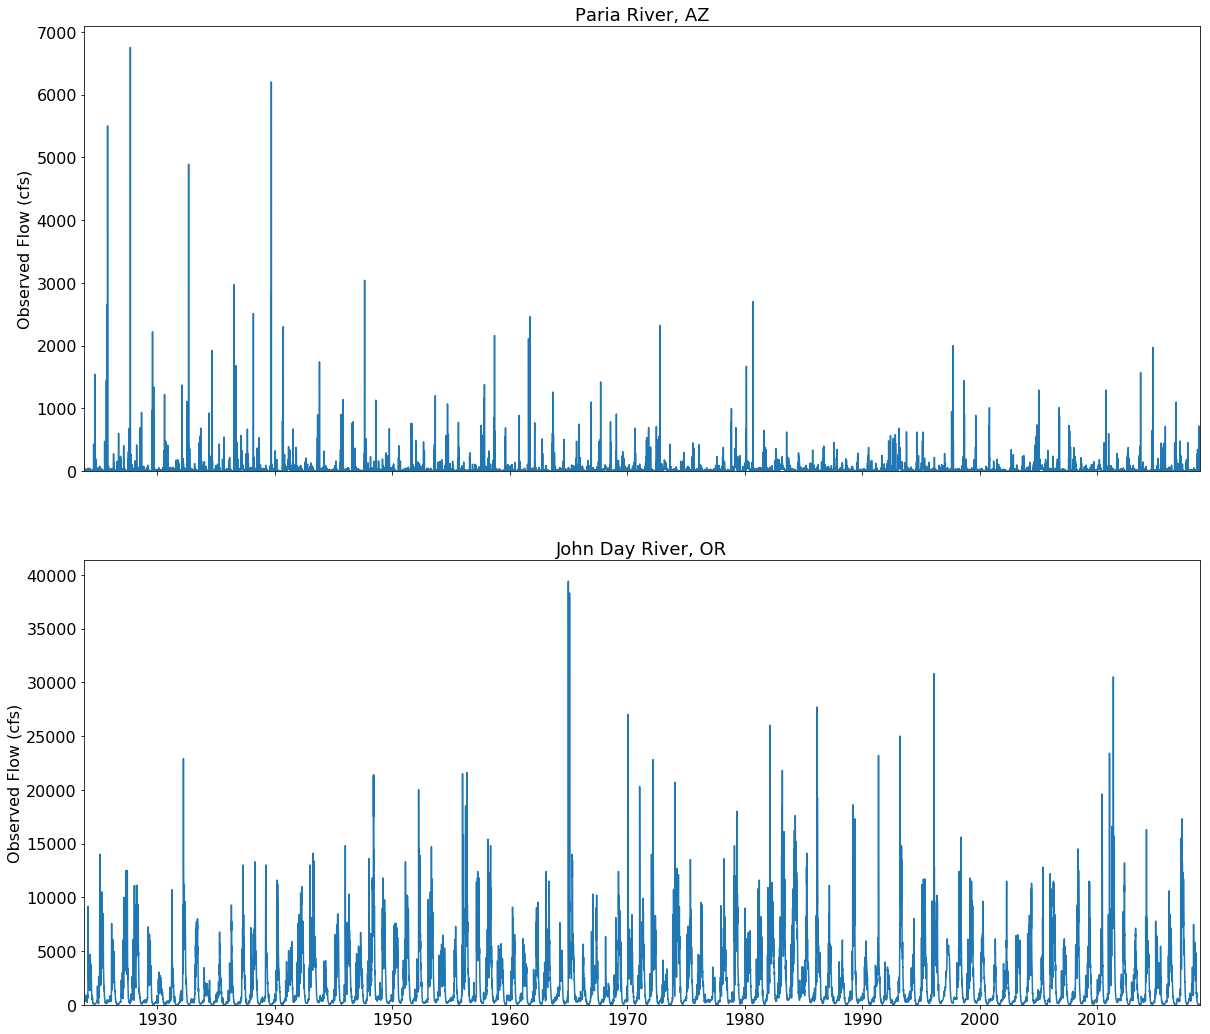

In [2]:
# plot the data sets
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 18))
ax[0].plot(df_az.DATE, df_az.Flow)
ax[0].set(title='Paria River, AZ')
ax[1].plot(df_or.DATE, df_or.Flow)
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[df_az.DATE.tolist()[0], df_az.DATE.tolist()[-1]], ylabel='Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

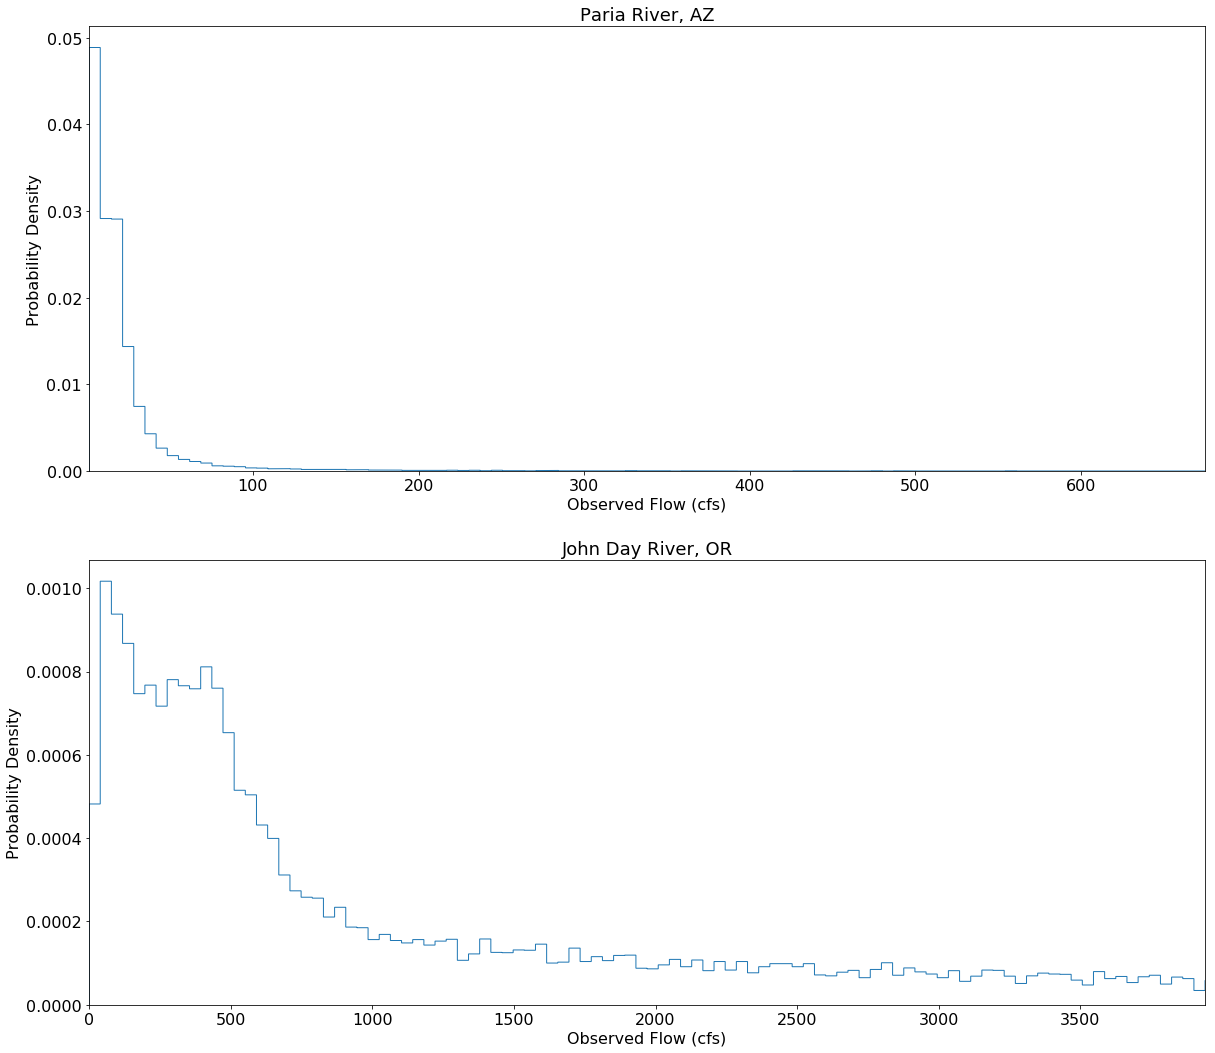

In [3]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].hist(df_az.Flow, density=True, histtype='step', bins=1000)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_az.Flow), 0.1*max(df_az.Flow)])
ax[1].hist(df_or.Flow, density=True, histtype='step', bins=1000)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_or.Flow), 0.1*max(df_or.Flow)])
plt.show()

In [4]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [df_az, df_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [df_az, df_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",27.981293,1.276292e+04,3.627005e+07,1.707285e+11,3.911651
"John Day River, OR",2021.069110,1.152401e+07,1.077329e+11,1.472558e+15,1.349536


### b. Suggest two plausible models for such histograms, fitting them using the moments. Plot your results and comment on whether one of the models turns out to be better than the other.

Two plausible models would be exponential or lognormal distributions, based on the right-skewness and decay.

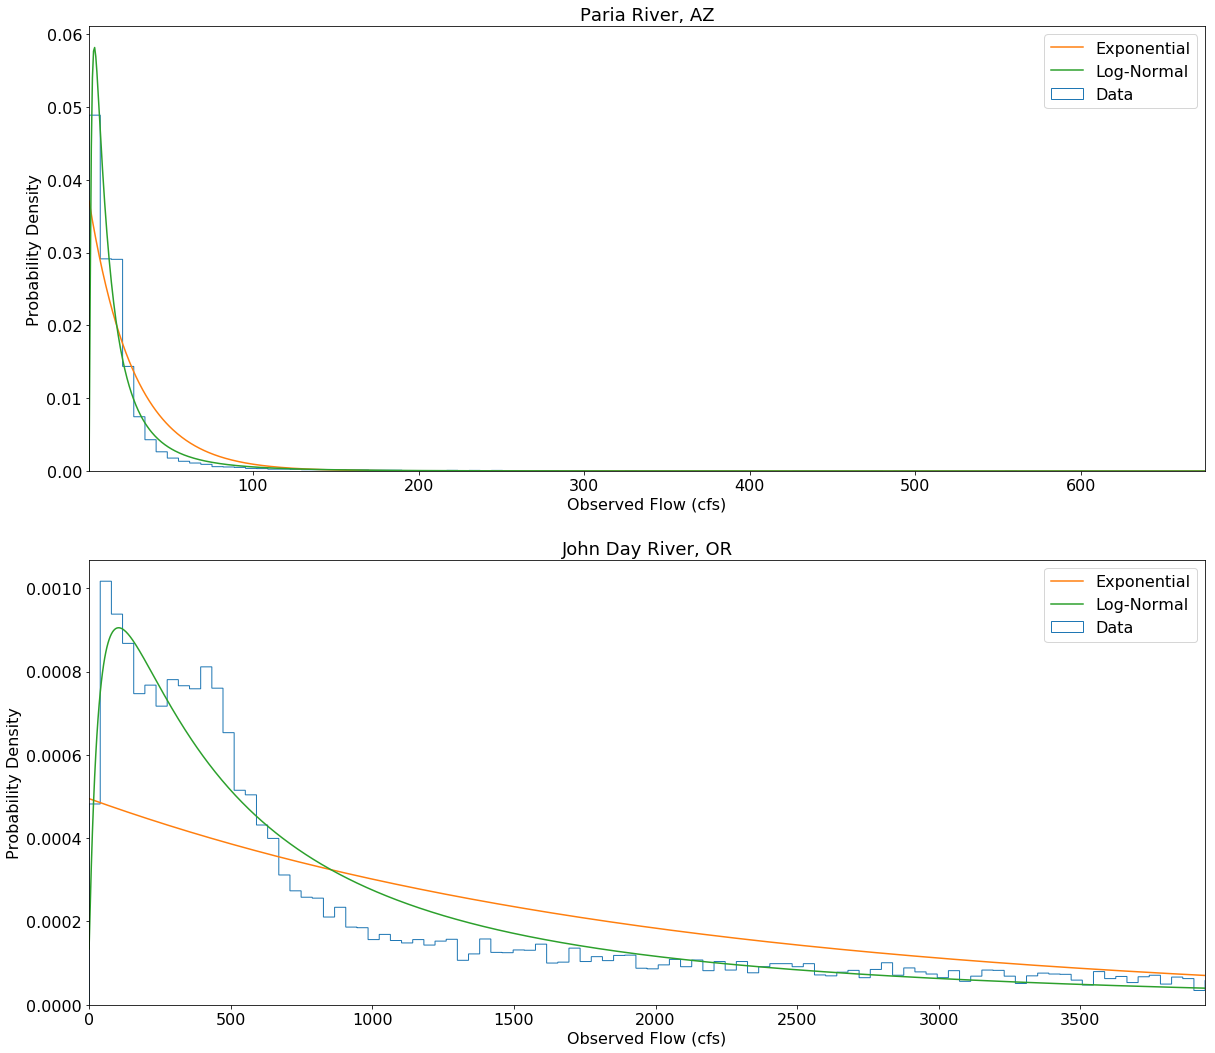

In [5]:
distributions = [stats.expon, stats.lognorm]
dist_names = ['Exponential', 'Log-Normal']

fig, ax = plt.subplots(2, 1, figsize=(20, 18))
for i, df in enumerate([df_az, df_or]):
    ax[i].hist(df.Flow, density=True, histtype='step', bins=1000, label='Data')
    for di, dist in enumerate(distributions):
        params = dist.fit(df.Flow)
        x = np.linspace(min(df.Flow), 0.1*max(df.Flow), 1001)
        fitted_pdf = dist.pdf(x, *params)
        ax[i].plot(x, fitted_pdf, label=dist_names[di])
        ax[i].set(xlabel='Observed Flow (cfs)', ylabel='Probability Density',
                  xlim=[min(df.Flow), 0.1*max(df.Flow)])
        ax[i].legend()
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

For both rivers, the lognormal distribution matches the data much more closely than the exponential.

### c. Find the autocorrelation function of the records, extending your calculations to a lag equal to a tenth of the data length. Plot your results and comment on the relative decays on the data sets. What are the scales of the sets?

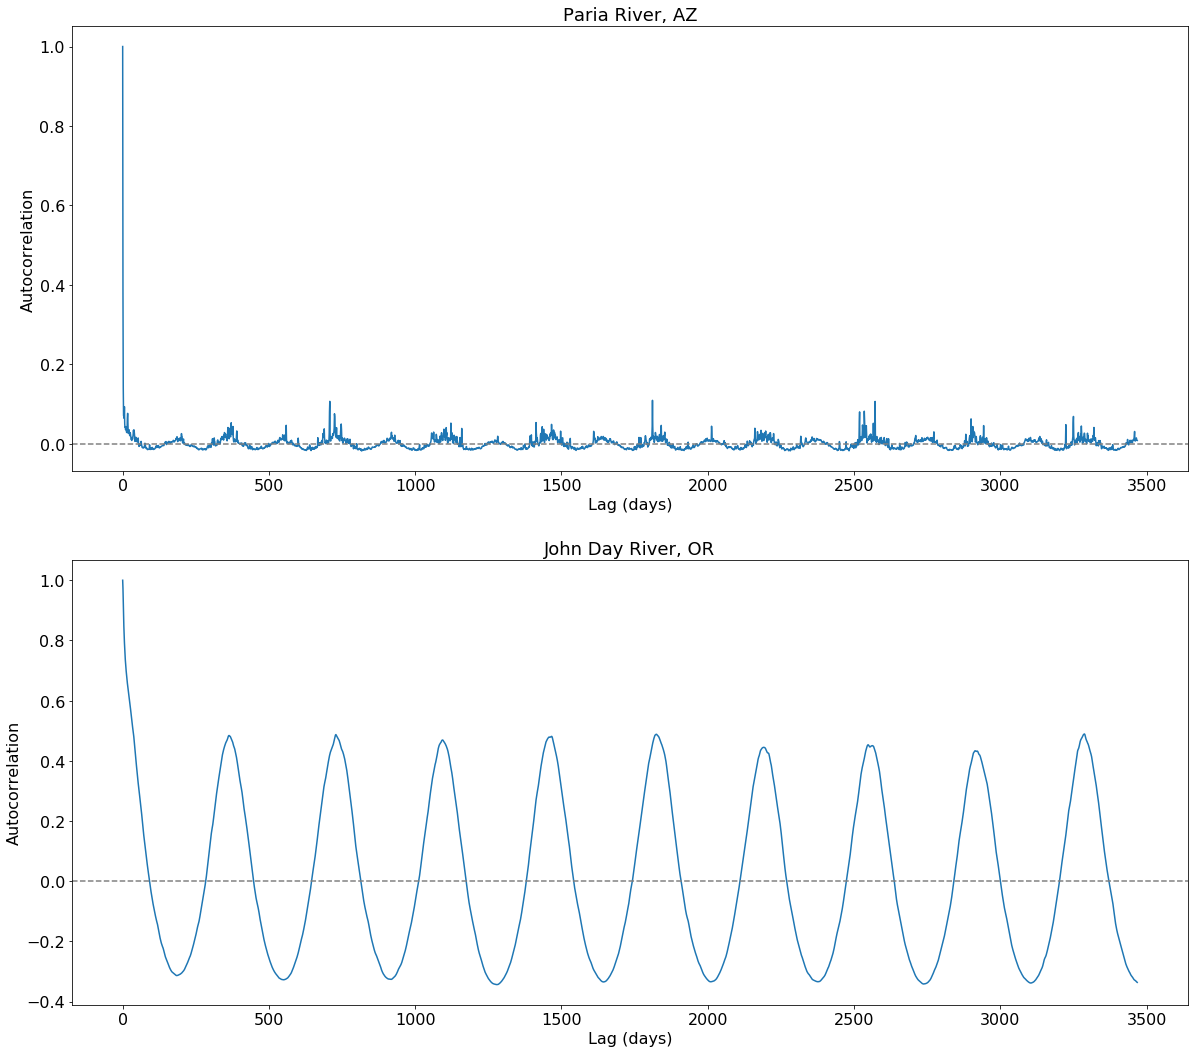

In [6]:
def acf(series, maxlags='default'):
    if maxlags == 'default':
        maxlags = len(series)//10
    lags = np.arange(maxlags)
    acorr = [1] + [np.corrcoef(series[:-lag], series[lag:])[0,1] for lag in lags[1:]]
    return lags, acorr

fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(*acf(df_az.Flow))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(df_or.Flow))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (days)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

The John Day River in Oregon decays much more slowly than the Paria River. Both exhibit annual oscillations indicative of periodicity. The John Day River oscillations have much higher amplitudes, indicative of the larger scale/longer memory of the system. This is expected since there is likely more gradual changes in the hydrograph due to a baseflow provided by groundwater and more temperate climate/regular precipitation patterns. In contrast, the Paria River is in an arid setting which exhibits much more flashy, temporally heterogeneous discharge patterns, so there is less correlation.

The scale of the Paria River streamflow is 55 days, while the scale of the John Day River streamflow is 92 days.

### Repeat parts a-c dividing each data set into two sets (the first and the second halves) in order to test for stationarity, that is, in order to see if results already found are stable.

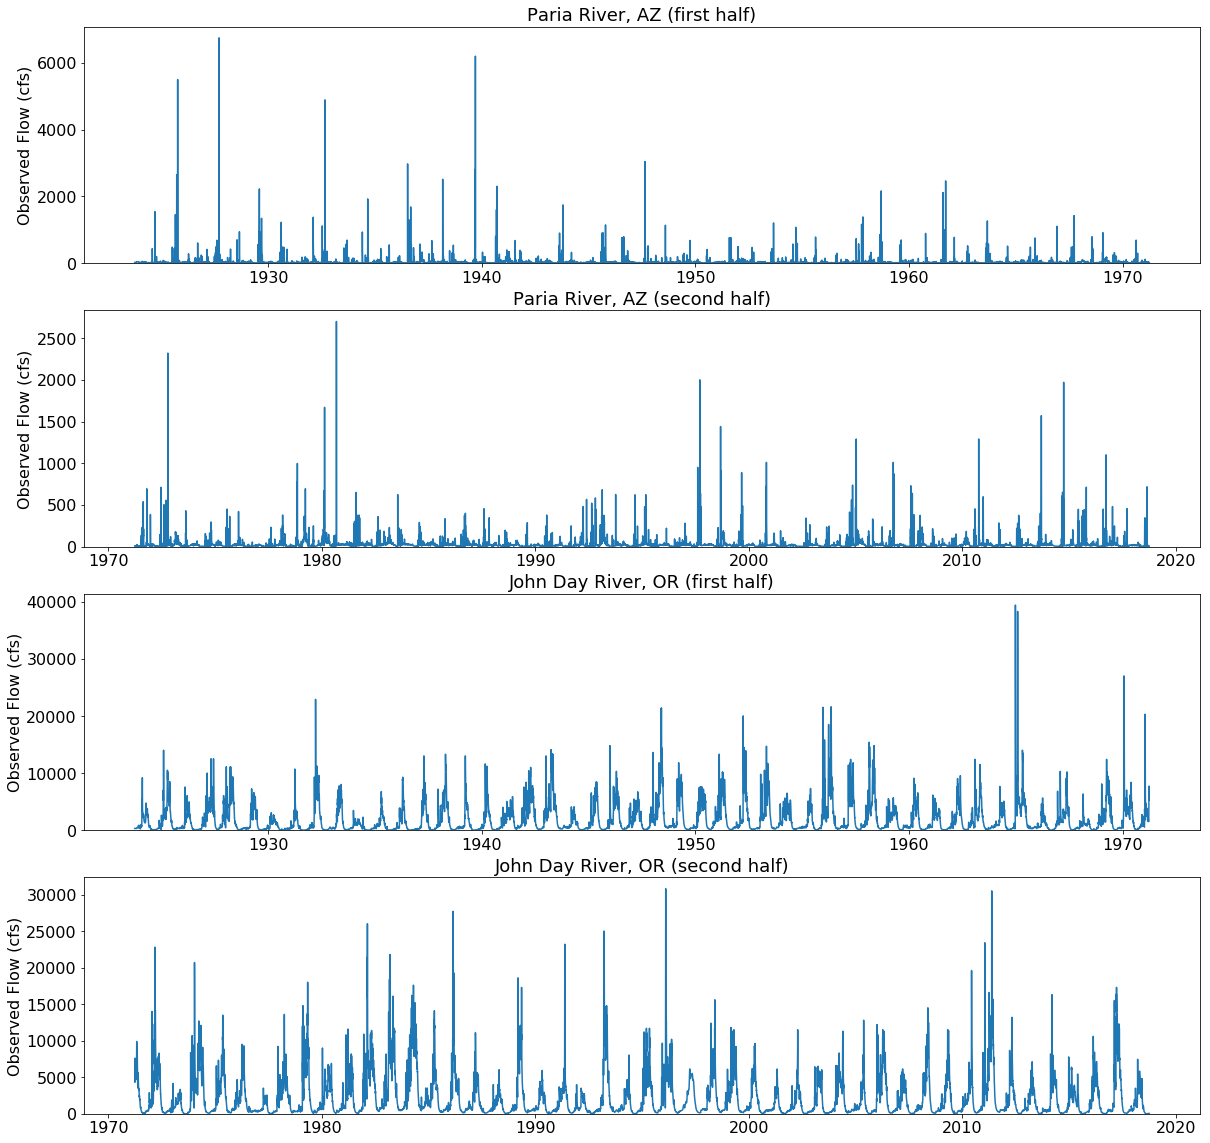

In [7]:
sdf_az = [df_az[:len(df_az)//2], df_az[len(df_az)//2:]]
sdf_or = [df_or[:len(df_or)//2], df_or[len(df_or)//2:]]

# plots
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
ax[0].plot(sdf_az[0].DATE, sdf_az[0].Flow)
ax[0].set(title='Paria River, AZ (first half)')
ax[1].plot(sdf_az[1].DATE, sdf_az[1].Flow)
ax[1].set(title='Paria River, AZ (second half)')
ax[2].plot(sdf_or[0].DATE, sdf_or[0].Flow)
ax[2].set(title='John Day River, OR (first half)')
ax[3].plot(sdf_or[1].DATE, sdf_or[1].Flow)
ax[3].set(title='John Day River, OR (second half)')
for axis in ax:
    axis.set(ylabel='Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

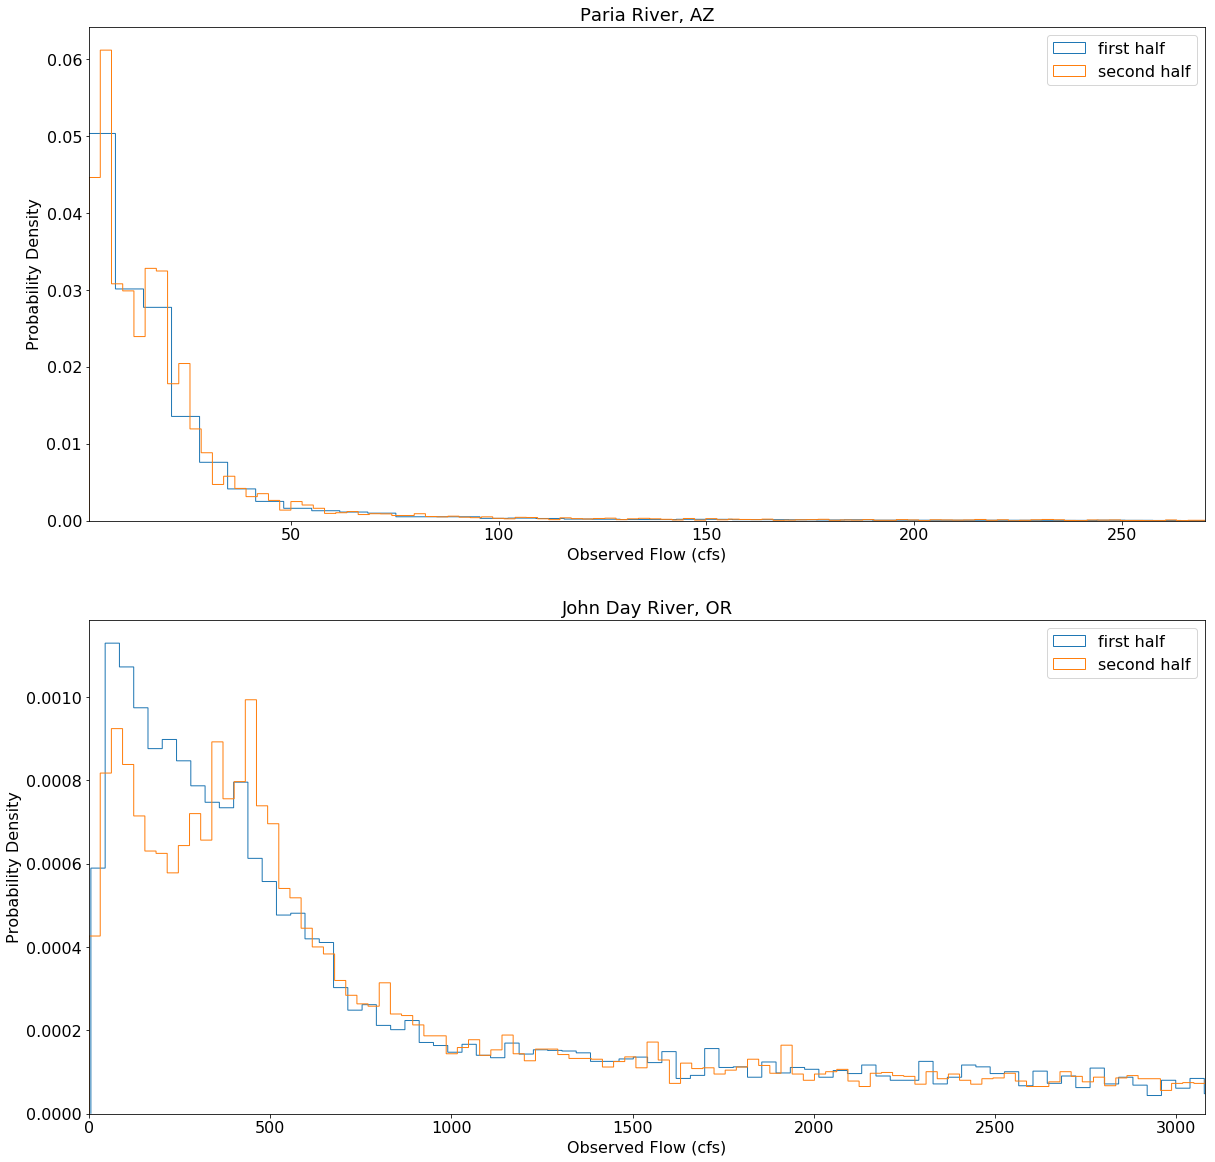

In [8]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].hist(sdf_az[0].Flow, density=True, histtype='step', bins=1000, label='first half')
ax[0].hist(sdf_az[1].Flow, density=True, histtype='step', bins=1000, label='second half')
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_az[1].Flow), 0.1*max(sdf_az[1].Flow)])
ax[1].hist(sdf_or[0].Flow, density=True, histtype='step', bins=1000, label='first half')
ax[1].hist(sdf_or[1].Flow, density=True, histtype='step', bins=1000, label='second half')
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_or[1].Flow), 0.1*max(sdf_or[1].Flow)])
for axis in ax:
    axis.legend()
plt.show()

In [9]:
# moments and cv
powers = np.arange(1, 5)
az_moments1, az_moments2, or_moments1, or_moments2 = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in sdf_az + sdf_or]
az_cv1, az_cv2, or_cv1, or_cv2 = [np.std(df.Flow)/np.mean(df.Flow) for df in sdf_az + sdf_or]

a_df = pd.DataFrame([az_moments1+[az_cv1], az_moments2+[az_cv2], or_moments1+[or_cv1], or_moments2+[or_cv2]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ (first half)', 'Paria River, AZ (second half)',
                          'John Day River, OR (first half)', 'John Day River, OR (second half)'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ (first half)",29.953087,1.964370e+04,6.605022e+07,3.296568e+11,4.571078
"Paria River, AZ (second half)",26.009613,5.882543e+03,6.491600e+06,1.180939e+10,2.774086
"John Day River, OR (first half)",1890.091631,1.025939e+07,9.497747e+10,1.395003e+15,1.368141
"John Day River, OR (second half)",2152.039041,1.278855e+07,1.204876e+11,1.550109e+15,1.327158


Comparing the moments and coefficient of variation, it appears that Paria River streamflows are nonstationary due to the significantly different magnitudes. In contrast, most John Day River values are within 10% of each other for the first and second halves, thus it might be approximated as a statioary process.

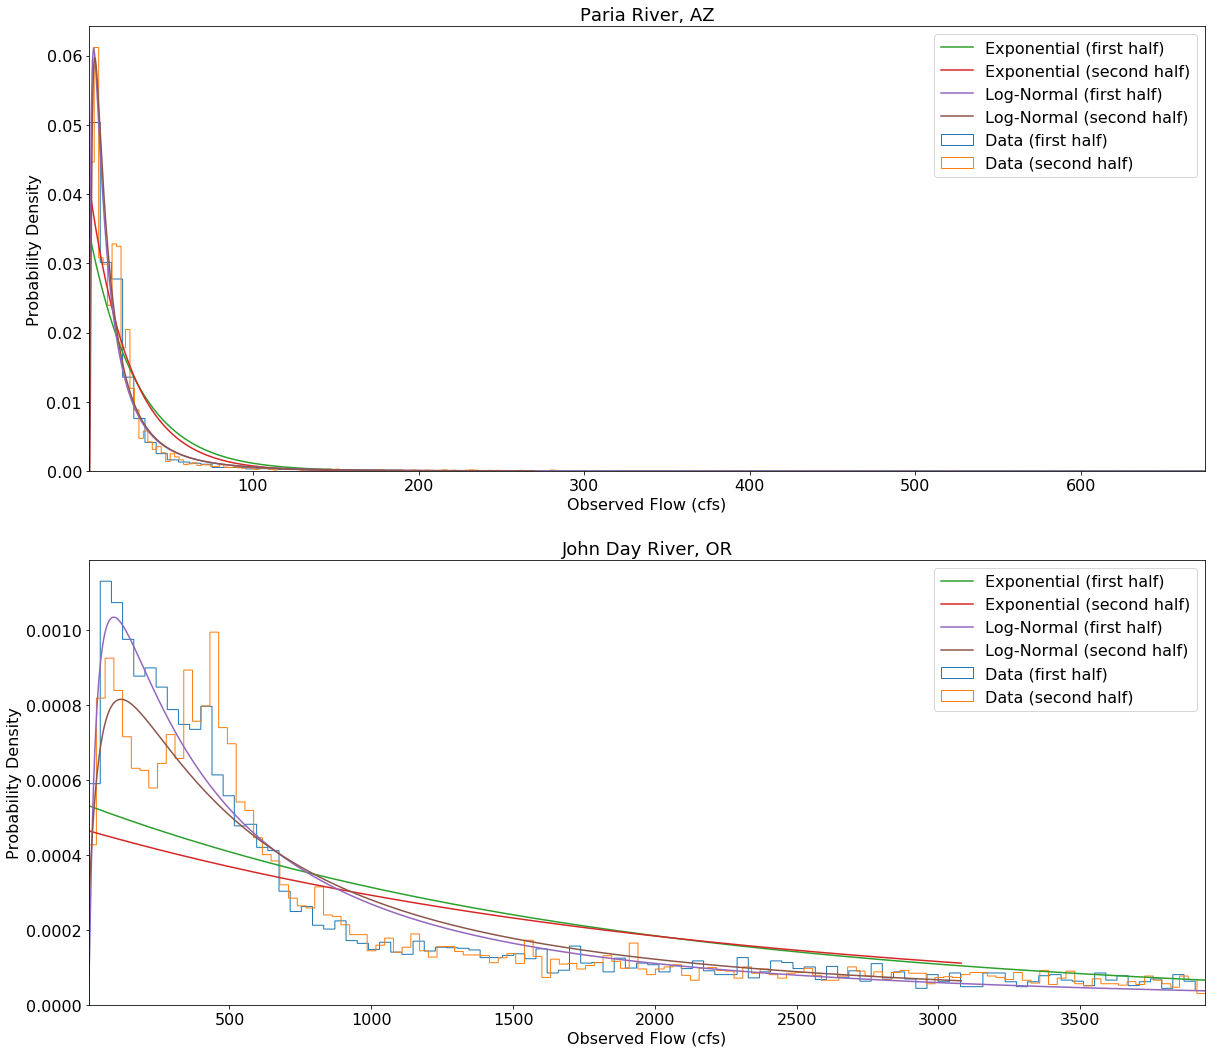

In [10]:
# fitting to models
distributions = [stats.expon, stats.lognorm]
dist_names = ['Exponential', 'Log-Normal']

fig, ax = plt.subplots(2, 1, figsize=(20, 18))
for i, dfl in enumerate([sdf_az, sdf_or]):
    ax[i].hist(dfl[0].Flow, density=True, histtype='step', bins=1000, label='Data (first half)')
    ax[i].hist(dfl[1].Flow, density=True, histtype='step', bins=1000, label='Data (second half)')
    for di, dist in enumerate(distributions):
        params = dist.fit(dfl[0].Flow)
        x = np.linspace(min(dfl[0].Flow), 0.1*max(dfl[0].Flow), 1001)
        fitted_pdf = dist.pdf(x, *params)
        ax[i].plot(x, fitted_pdf, label=dist_names[di] + ' (first half)')
        params = dist.fit(dfl[1].Flow)
        x = np.linspace(min(dfl[1].Flow), 0.1*max(dfl[1].Flow), 1001)
        fitted_pdf = dist.pdf(x, *params)
        ax[i].plot(x, fitted_pdf, label=dist_names[di] + ' (second half)')
        
        ax[i].set(xlabel='Observed Flow (cfs)', ylabel='Probability Density',
                  xlim=[min(dfl[0].Flow), 0.1*max(dfl[0].Flow)])
        ax[i].legend()
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

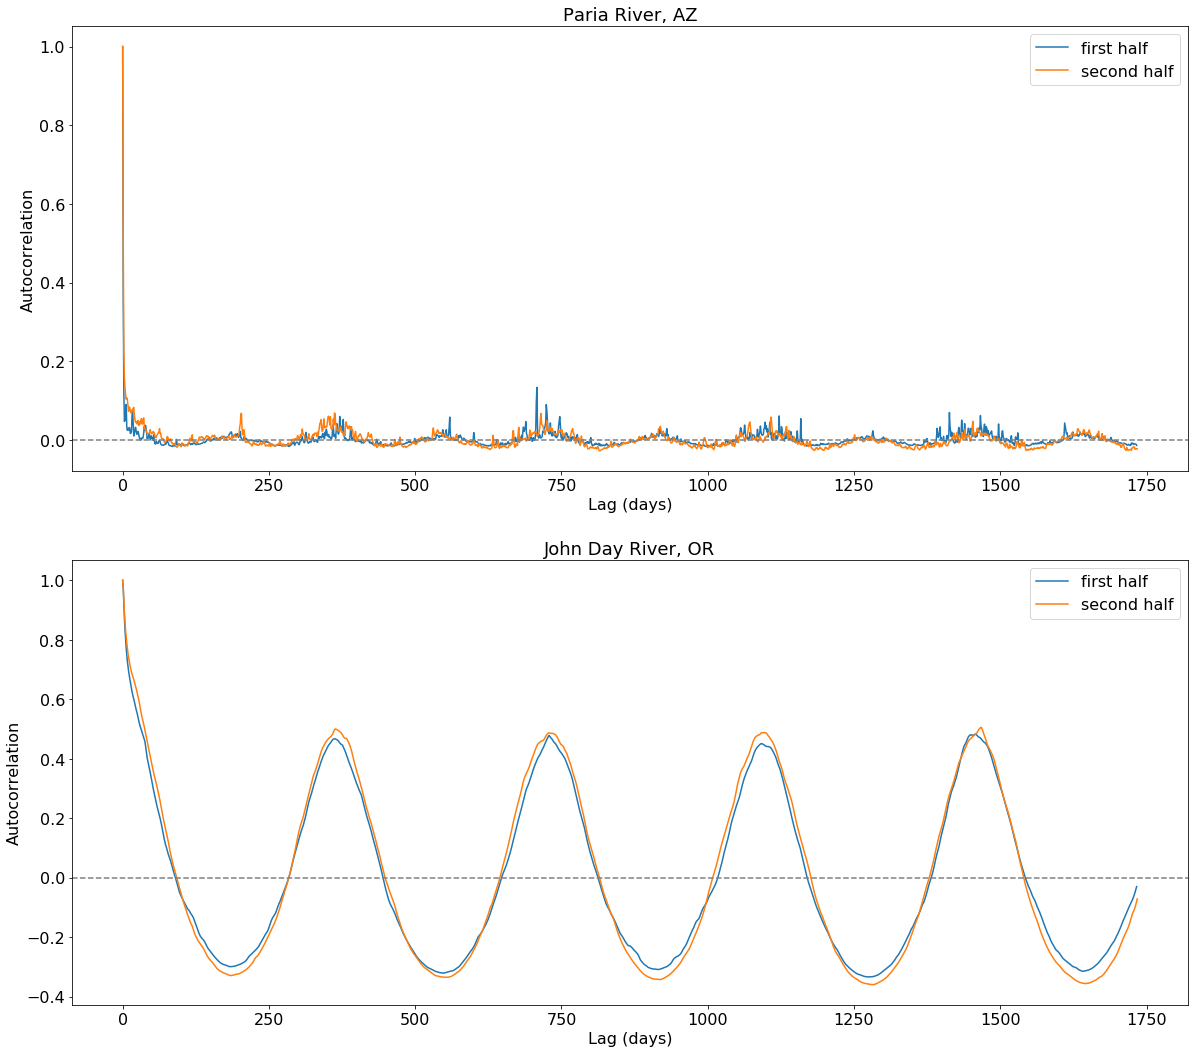

In [30]:
# autocorrelation and scale
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(*acf(sdf_az[0].Flow), label='first half')
ax[0].plot(*acf(sdf_az[1].Flow), label='second half')
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(sdf_or[0].Flow), label='first half')
ax[1].plot(*acf(sdf_or[1].Flow), label='second half')
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (days)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
    axis.legend()
plt.show()

There is no significant difference in the autocorrelation functions for the first and second half of each data set.

### Now aggregate daily discharge data sets into monthly discharge data sets.

In [12]:
for df in [df_az, df_or]:
    df['month'] = [d.month for d in df['DATE']]
    df['year'] = [d.year for d in df['DATE']]

per = df_az.DATE.dt.to_period("M")
mdf_az = df_az.groupby(per).sum()
per = df_or.DATE.dt.to_period("M")
mdf_or = df_or.groupby(per).sum()

### g. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.

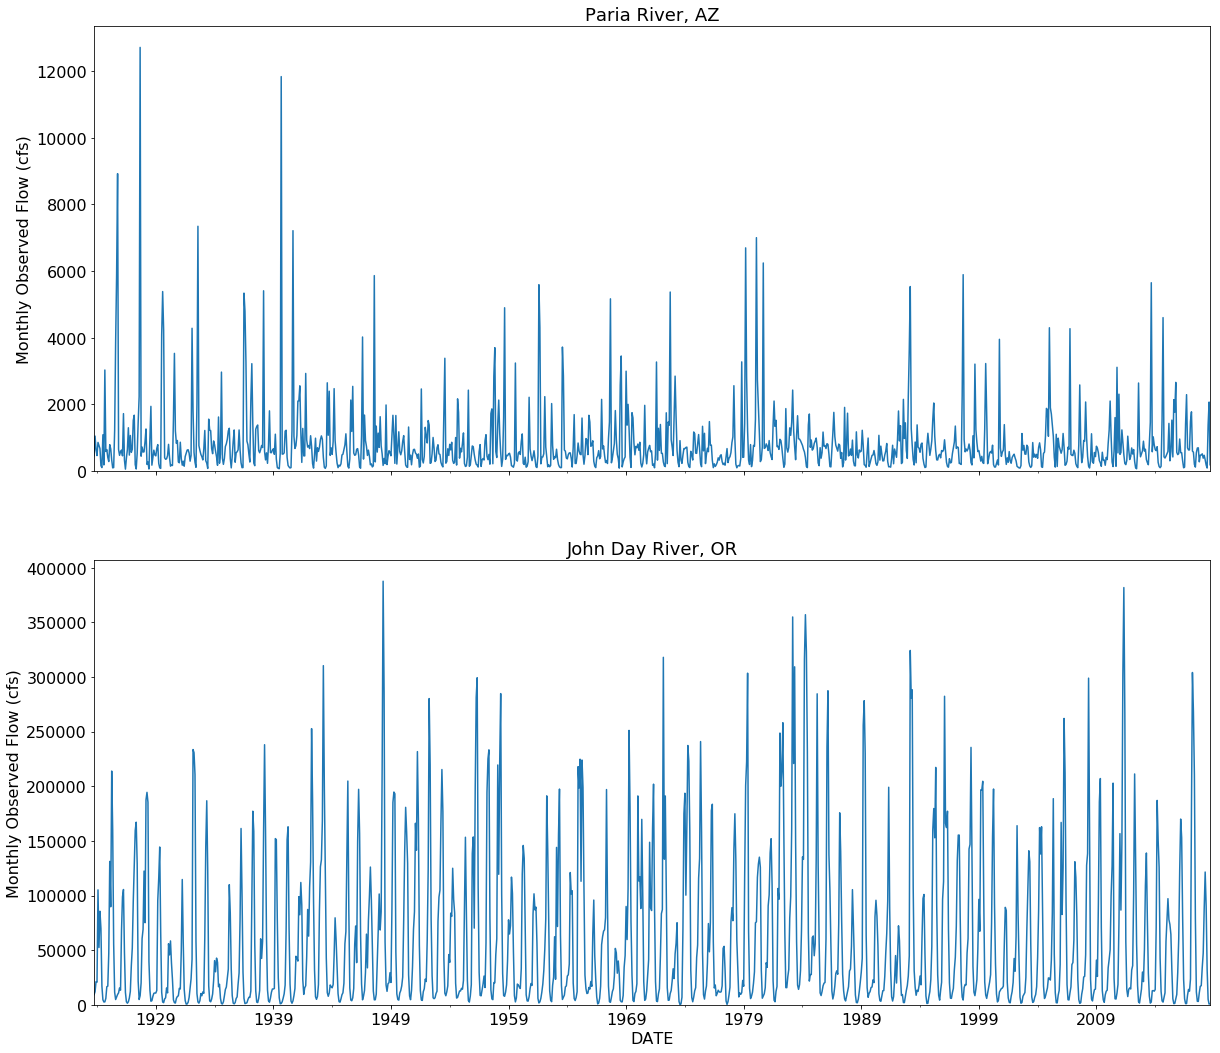

In [13]:
# plots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 18))
mdf_az.Flow.plot(ax=ax[0])
ax[0].set(title='Paria River, AZ')
mdf_or.Flow.plot(ax=ax[1])
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[mdf_az.index.tolist()[0], mdf_az.index.tolist()[-1]], ylabel='Monthly Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

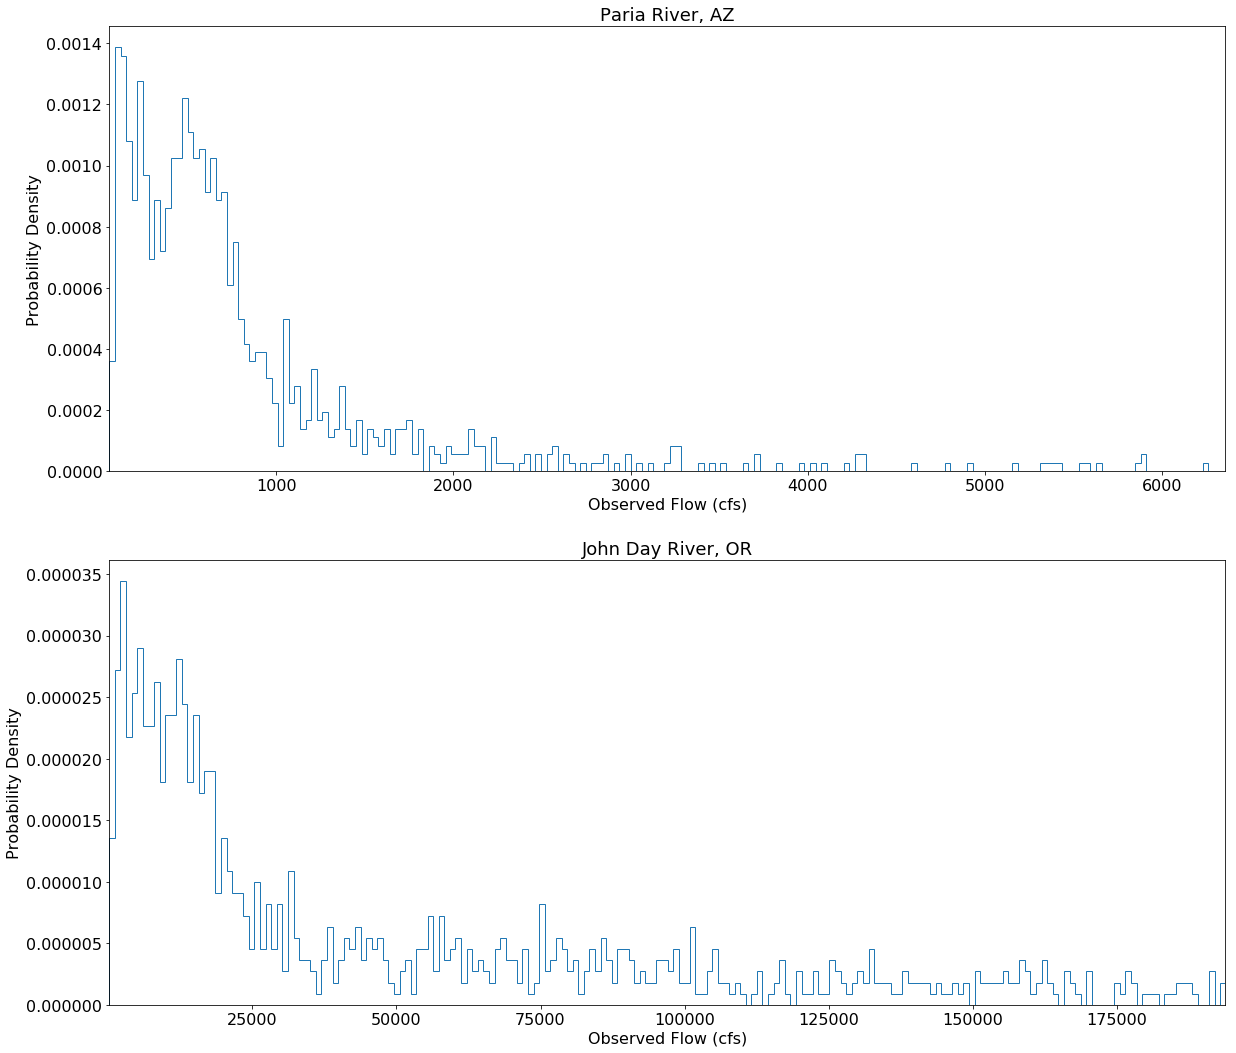

In [14]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].hist(mdf_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(mdf_az.Flow), 0.5*max(mdf_az.Flow)])
ax[1].hist(mdf_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(mdf_or.Flow), 0.5*max(mdf_or.Flow)])
plt.show()

In [15]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [mdf_az, mdf_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [mdf_az, mdf_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",851.686737,1.905891e+06,9.470471e+09,7.269506e+13,1.275725
"John Day River, OR",61516.734263,8.940134e+09,1.781588e+15,4.188143e+20,1.167228


### h. Find the autocorrelation function of the new records, extending your calculations to a lag equal to a quarter of the data length. Plot your results and comment on the trends and relative decays on the two datasets.

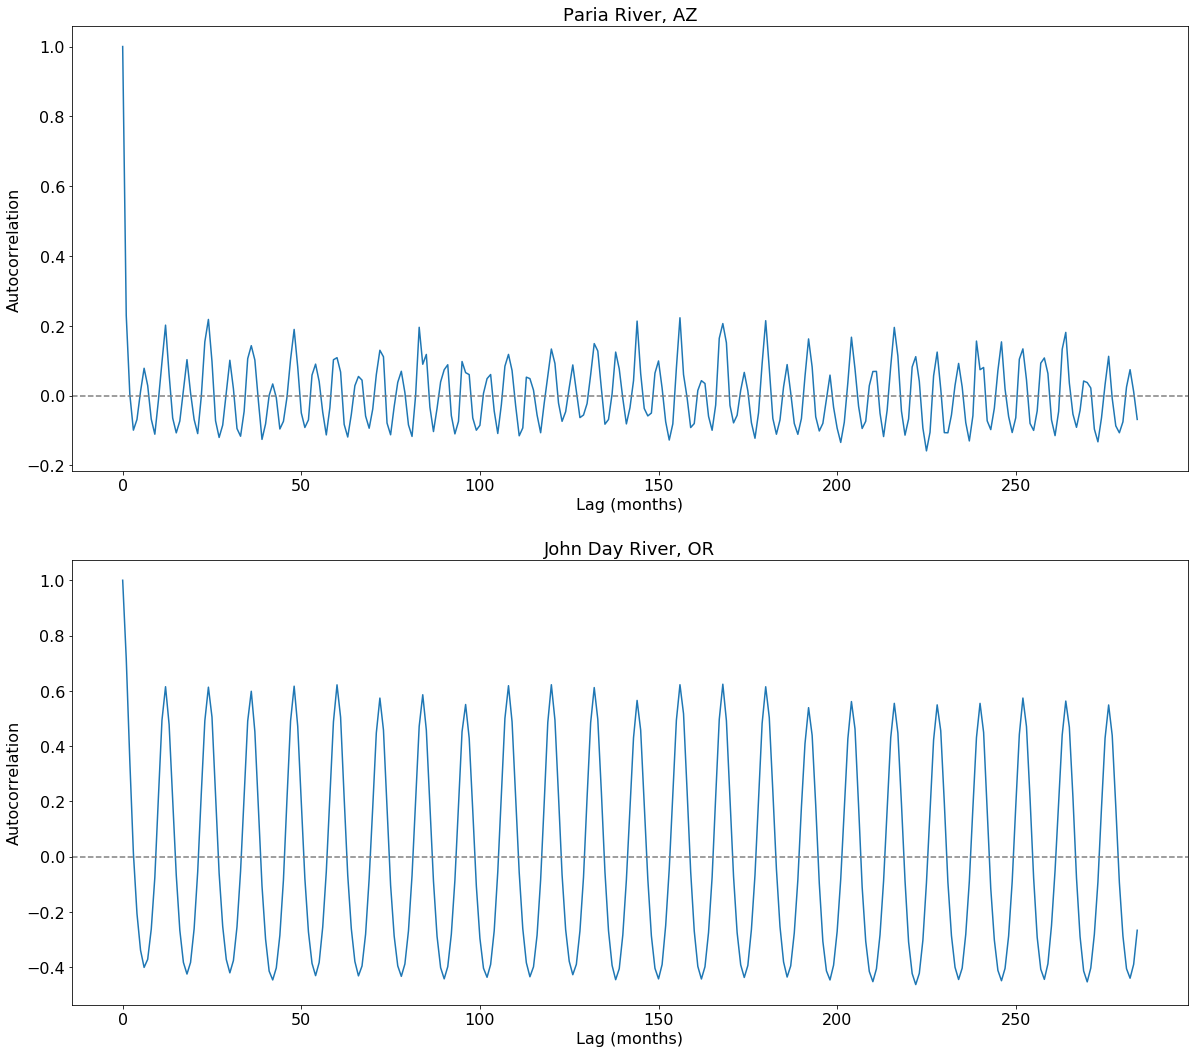

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(*acf(mdf_az.Flow, maxlags=len(mdf_az.Flow)//4))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(mdf_or.Flow, maxlags=len(mdf_or.Flow)//4))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (months)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

As expected, there is periodicity in both autocorrelation functions due to seasonal variability. The Paria River has a scale of 3 months, while the John Day River has a scale of 4 months.

### Finally, aggregate all data sets to a yearly scale.

In [17]:
per = df_az.DATE.dt.to_period("A")
ydf_az = df_az.groupby(per).sum()
per = df_or.DATE.dt.to_period("A")
ydf_or = df_or.groupby(per).sum()

### k. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.

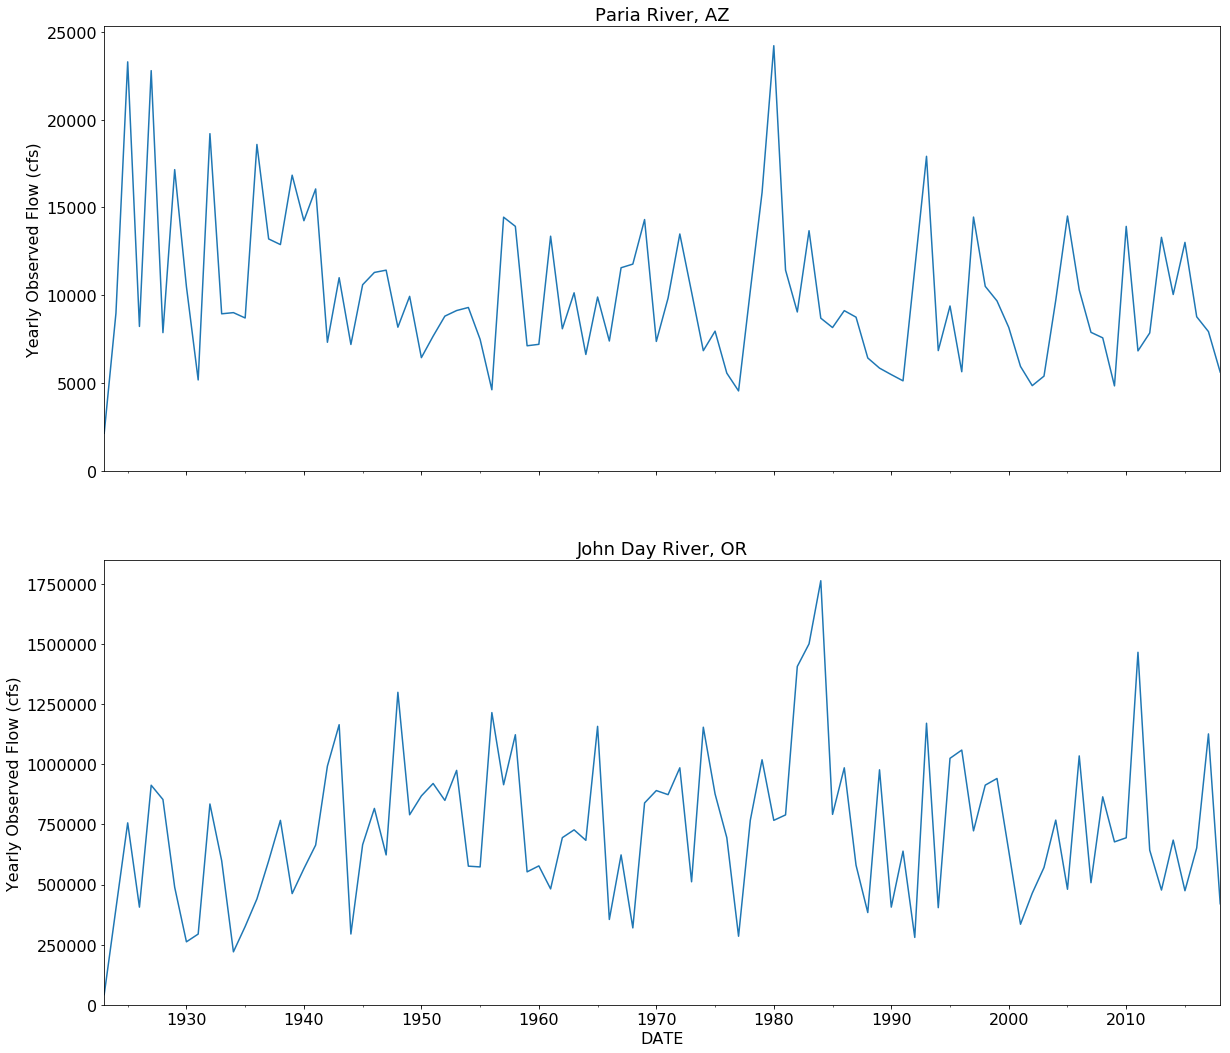

In [18]:
# plots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 18))
ydf_az.Flow.plot(ax=ax[0])
ax[0].set(title='Paria River, AZ')
ydf_or.Flow.plot(ax=ax[1])
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[ydf_az.index.tolist()[0], ydf_az.index.tolist()[-1]], ylabel='Yearly Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

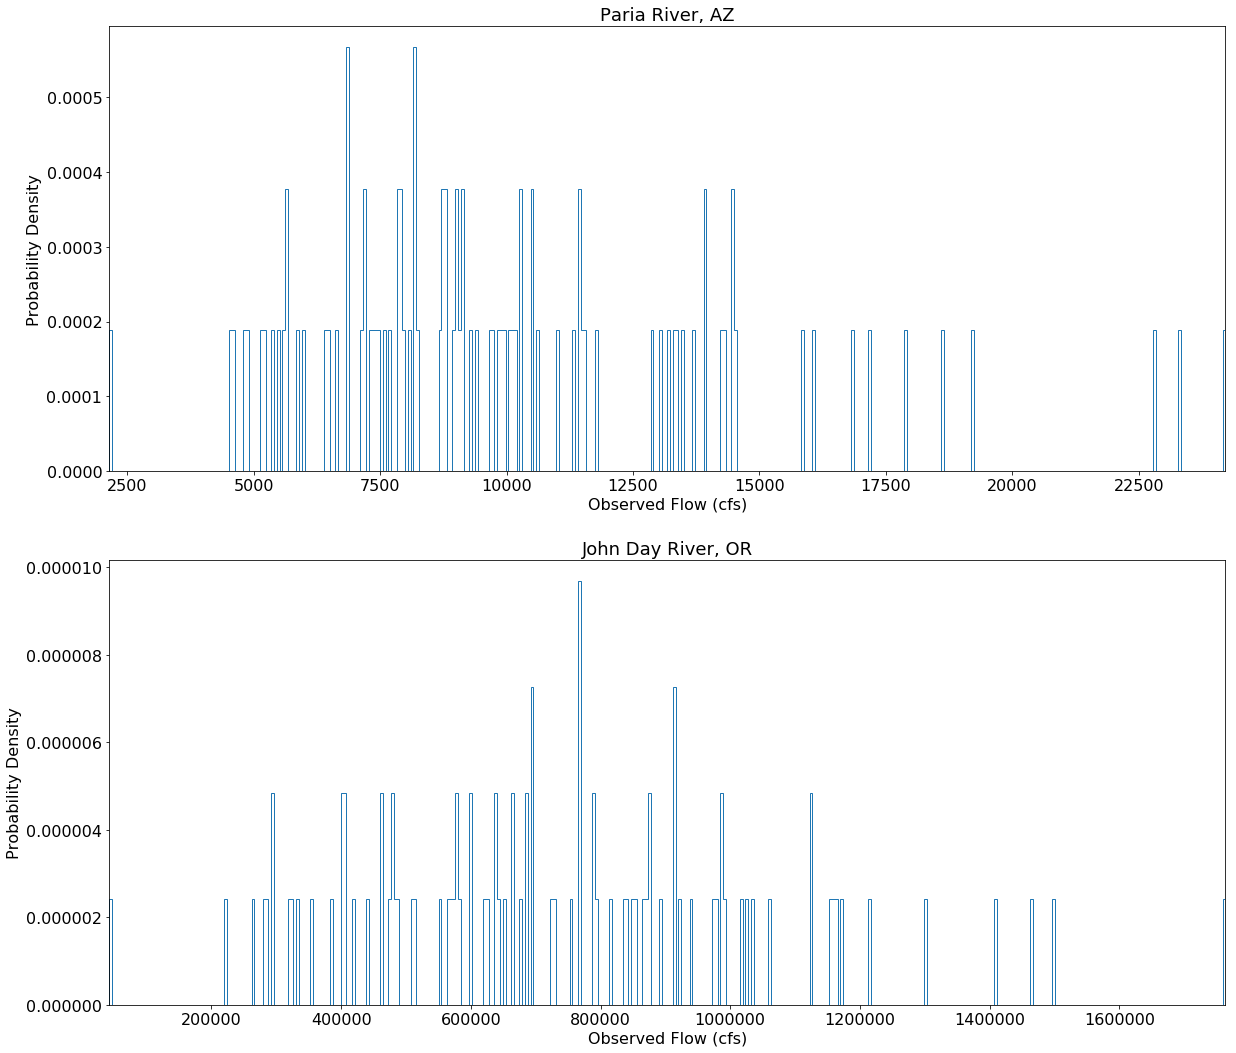

In [19]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].hist(ydf_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(ydf_az.Flow), max(ydf_az.Flow)])
ax[1].hist(ydf_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(ydf_or.Flow), max(ydf_or.Flow)])
plt.show()

In [20]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [ydf_az, ydf_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [ydf_az, ydf_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",10113.780000,1.198214e+08,1.652009e+12,2.607573e+16,0.414012
"John Day River, OR",730511.219375,6.300818e+11,6.187933e+17,6.774759e+23,0.425100


### l. Find the autocorrelation function of the records, extending your calculations to a lag equal to a quarter of the data length. Plot your results and comment on the trends and relative decays on the two data sets.

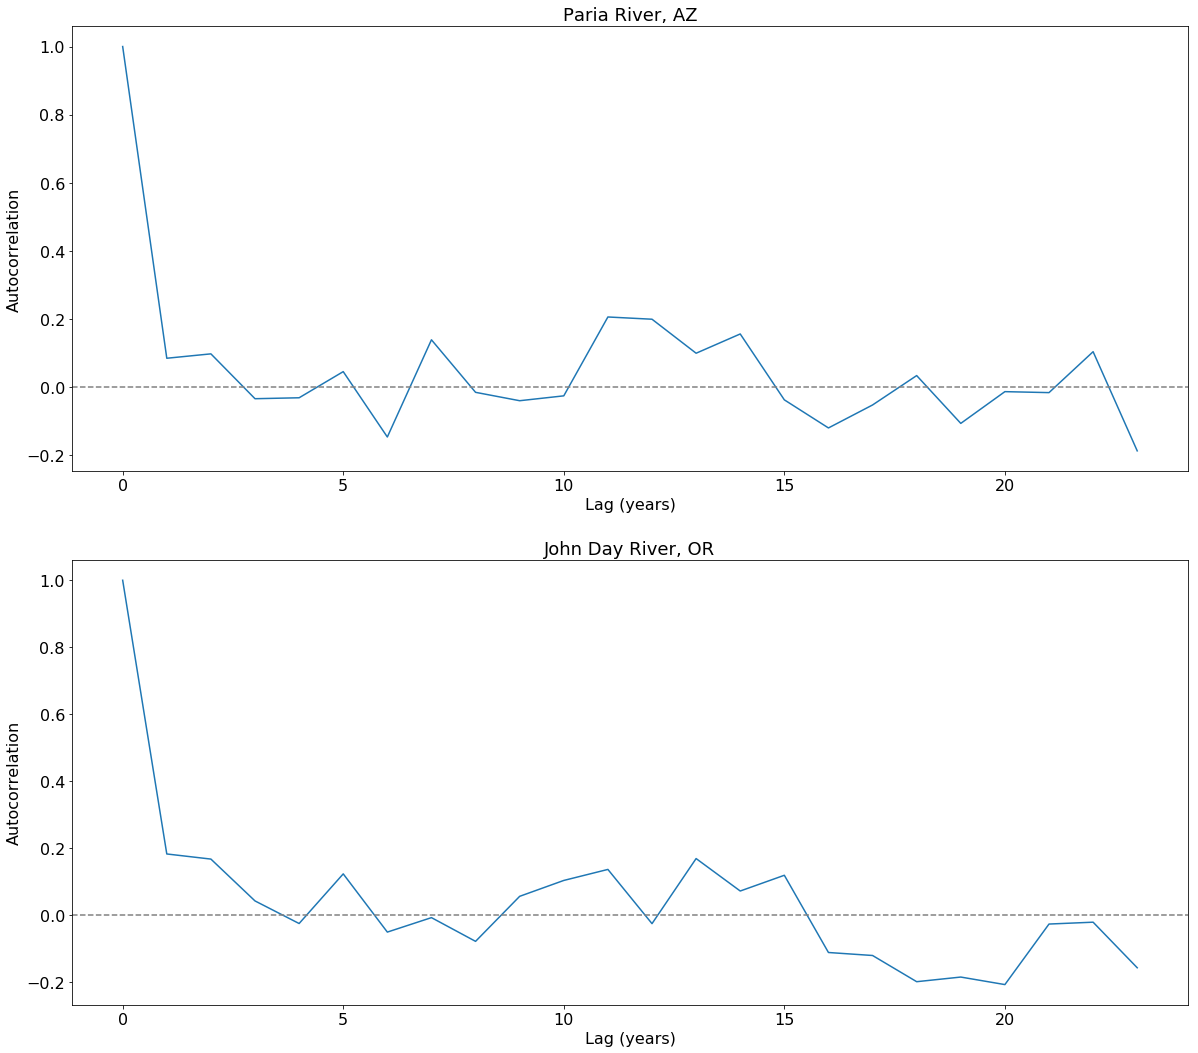

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(*acf(ydf_az.Flow, maxlags=len(ydf_az.Flow)//4))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(ydf_or.Flow, maxlags=len(ydf_or.Flow)//4))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (years)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

There appears to be a lack of periodicity for annually aggregate data. The autocorrelation for both datasets generally decays and then fluctuates around zero, similarly to an $AR(1)$ process. The scale of the Paria River is 3 years and the scale of the John Day river is 4 years. 

### m. Is the decay in autocorrelations consistent with simple time series models? Try AR(1), AR(2) and ARMA(1,1). Compute the power spectrum for the records. Is such consistent with power-law fractal noises?

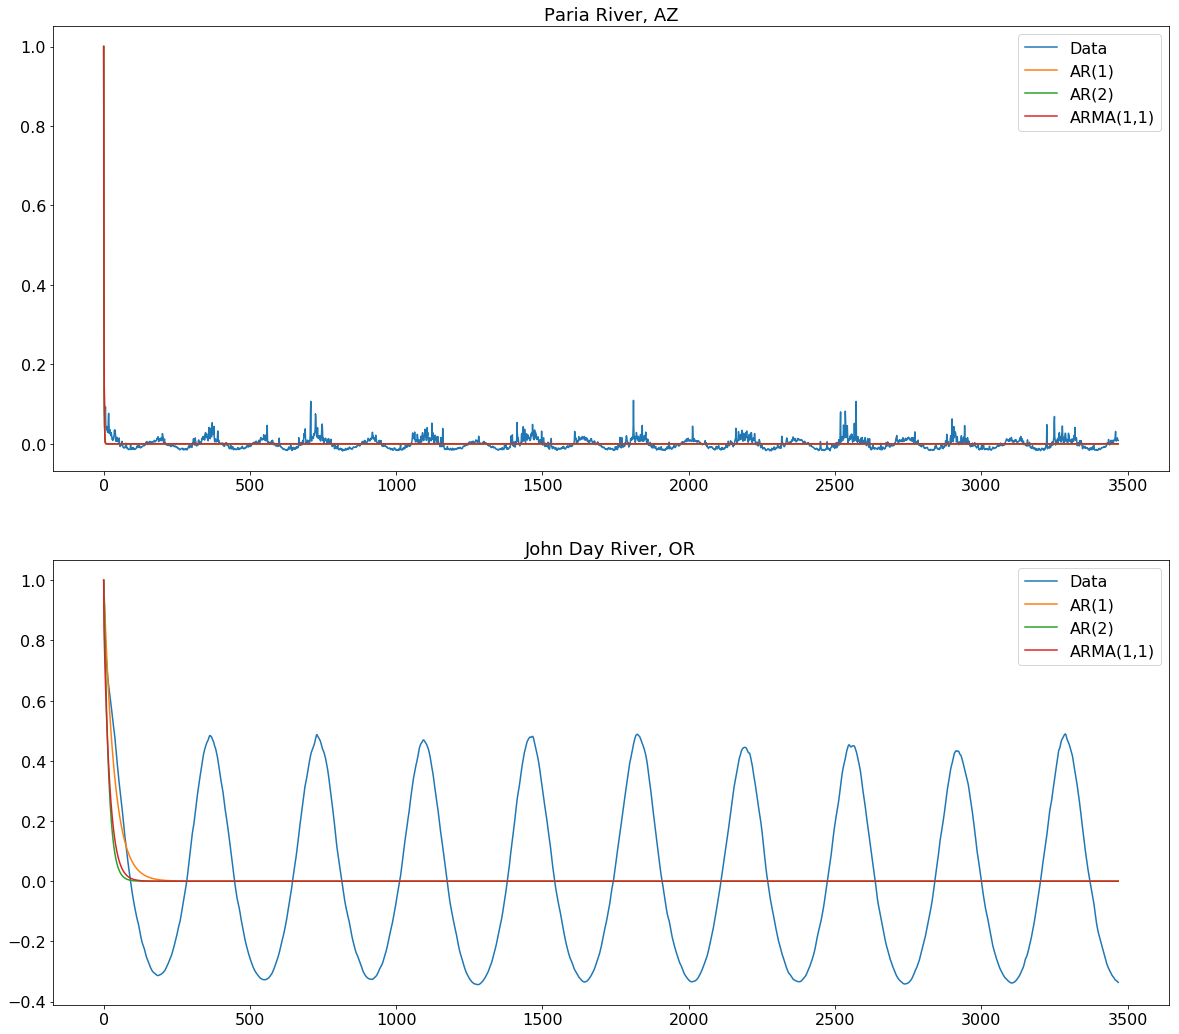

In [22]:
from statsmodels.tsa.arima_model import ARMA

fig, ax = plt.subplots(2, 1, figsize=(20,18))
for i,df in enumerate([df_az, df_or]):
    # plot data autocorrelation
    lags, acorr = acf(df.Flow)
    ax[i].plot(lags, acorr, label='Data')
    # AR(1)
    c, phi = ARMA(df.Flow, order=(1,0)).fit().params
    ax[i].plot(lags, [phi**lag for lag in lags], label='AR(1)')
    # AR(2)
    c, phi_1, phi_2 = ARMA(df.Flow, order=(2,0)).fit().params
    ar2acorr = [1, phi_1/(1-phi_2)]
    for k in lags[2:]:
        ar2acorr.append(phi_1*ar2acorr[k-1] + phi_2*ar2acorr[k-2])
    ax[i].plot(lags, ar2acorr, label='AR(2)')
    # ARMA(1,1)
    c, phi, theta = ARMA(df.Flow, order=(1,1)).fit().params
    arma_acorr = [1, (1-phi*theta)*(phi-theta)/(1+theta**2-2*phi*theta)]
    for k in lags[2:]:
        arma_acorr.append(phi*arma_acorr[k-1])
    ax[i].plot(lags, arma_acorr, label='ARMA(1,1)')
    ax[i].legend()
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

The decay in autocorrelations is not consistent with the simple ARMA models. While the models fairly approximate the initial decay, they do not capture the subsequent periodicity of autocorrelations.

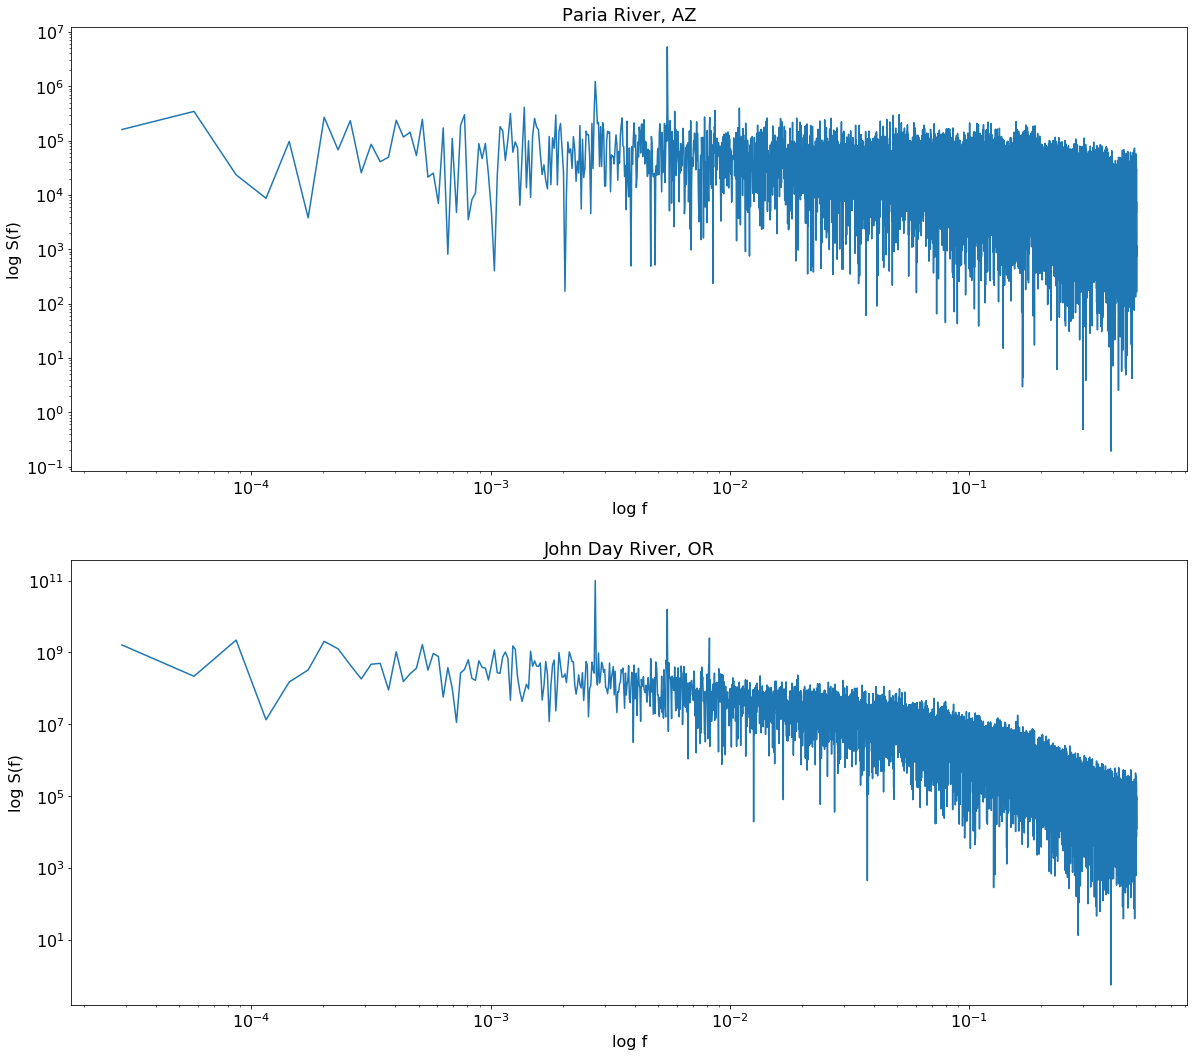

In [23]:
# spectral density
import scipy.signal as sig

fig, ax = plt.subplots(2, 1, figsize=(20,18))
for i, df in enumerate([df_az, df_or]):
    f, psd = sig.periodogram(df.Flow)
    ax[i].loglog(f[1:], psd[1:])
    ax[i].set(xlabel='log f', ylabel='log S(f)')
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

Neither spectrum is obviously linear in log-log space, so they do not appear to strongly resemble power-law fractal noises. However, if fit to a power law, the Paria River is approximately $1/f^{0.5}$ noise and the John Day River is approximately $1/f$ noise. Thus, the John Day River discharges likely make for better music.

### n. Find the rescaled range of the records and estimate their Hurst exponent. Is such related to the roughness seen on the records? Comment on the drought lengths associated with the diagrams. How unlikely are such conditions?

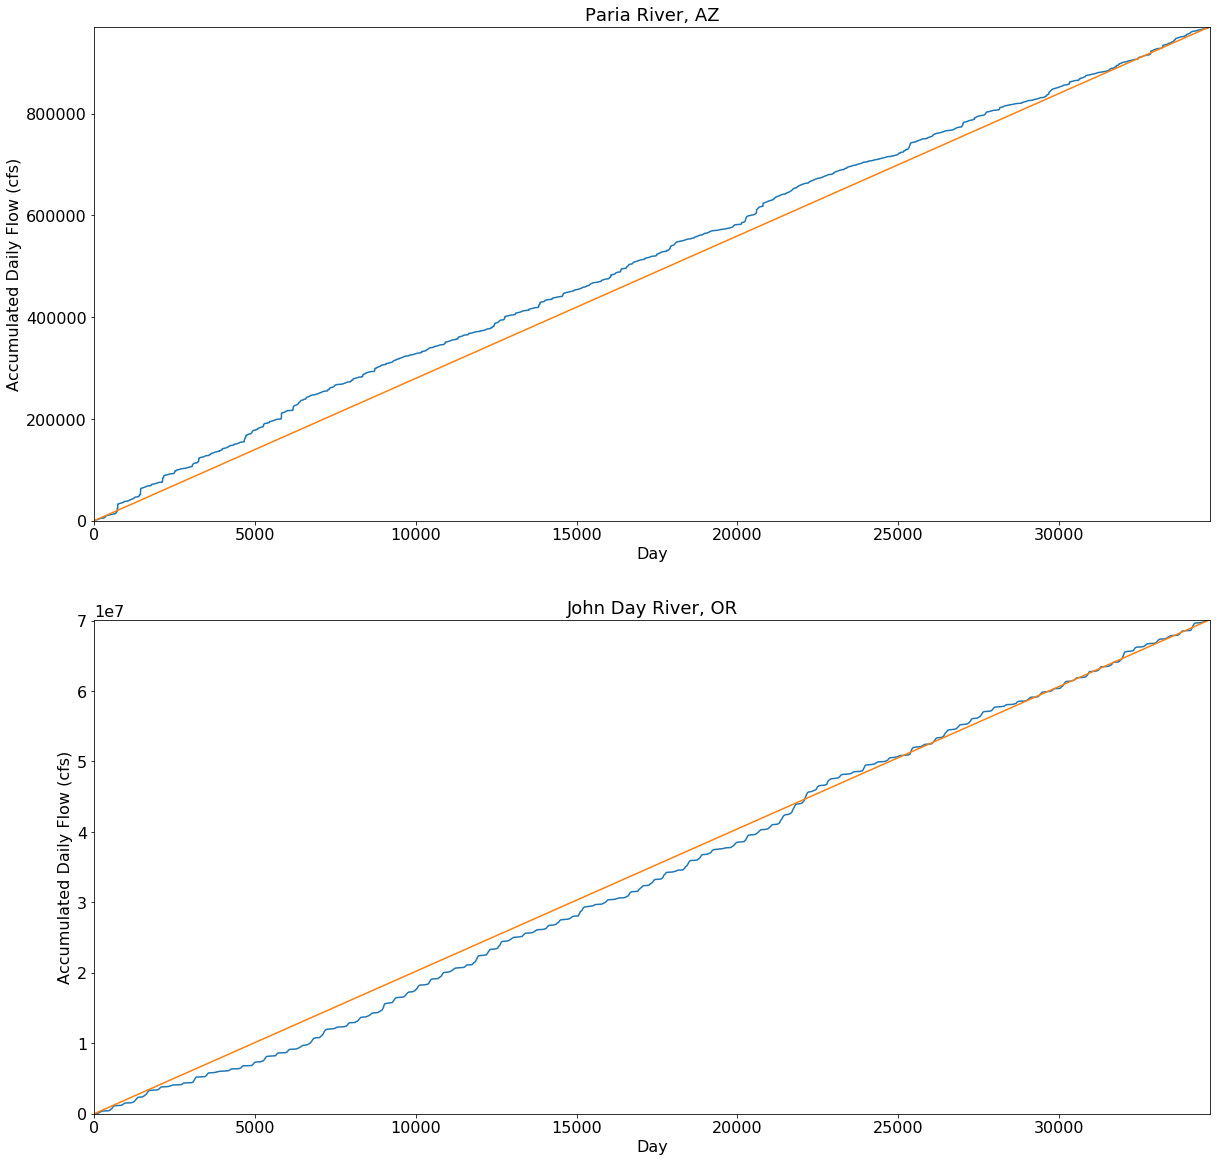

In [24]:
## accumulated flows
accum_az = []
accum_or = []
az_cum = 0
or_cum = 0
for i in range(len(df_az)):
    az_cum += df_az.Flow[i]
    or_cum += df_or.Flow[i]
    accum_az.append(az_cum)
    accum_or.append(or_cum)

# draw line from first to last
m = (accum_az[-1] - accum_az[0])*1.0/len(accum_az)
line_az = [m * x for x in range(len(accum_az))]
m = (accum_or[-1] - accum_or[0])*1.0/len(accum_or)
line_or = [m * x for x in range(len(accum_or))]

fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].plot(accum_az)
ax[0].plot(line_az)
ax[0].set(title='Paria River, AZ')
ax[0].set(ylim=[0, max(accum_az)])
ax[1].plot(accum_or)
ax[1].plot(line_or)
ax[1].set(title='John Day River, OR')
ax[1].set(ylim=[0, max(accum_or)])
for axis in ax:
    axis.set(xlabel='Day', ylabel='Accumulated Daily Flow (cfs)',
            xlim=[0, len(accum_az)])
plt.show()

# get residuals
res_az = [val - fit for val, fit in zip(accum_az, line_az)]
res_or = [val - fit for val, fit in zip(accum_or, line_or)]

# (max - min residual)/sigma for [:n] = range(n)
az_range = [(max(res_az[:n]) - min(res_az[:n]))/np.std(df_az.Flow[:n]) for n in range(32, len(df_az))]
or_range = [(max(res_or[:n]) - min(res_or[:n]))/np.std(df_or.Flow[:n]) for n in range(32, len(df_or))]

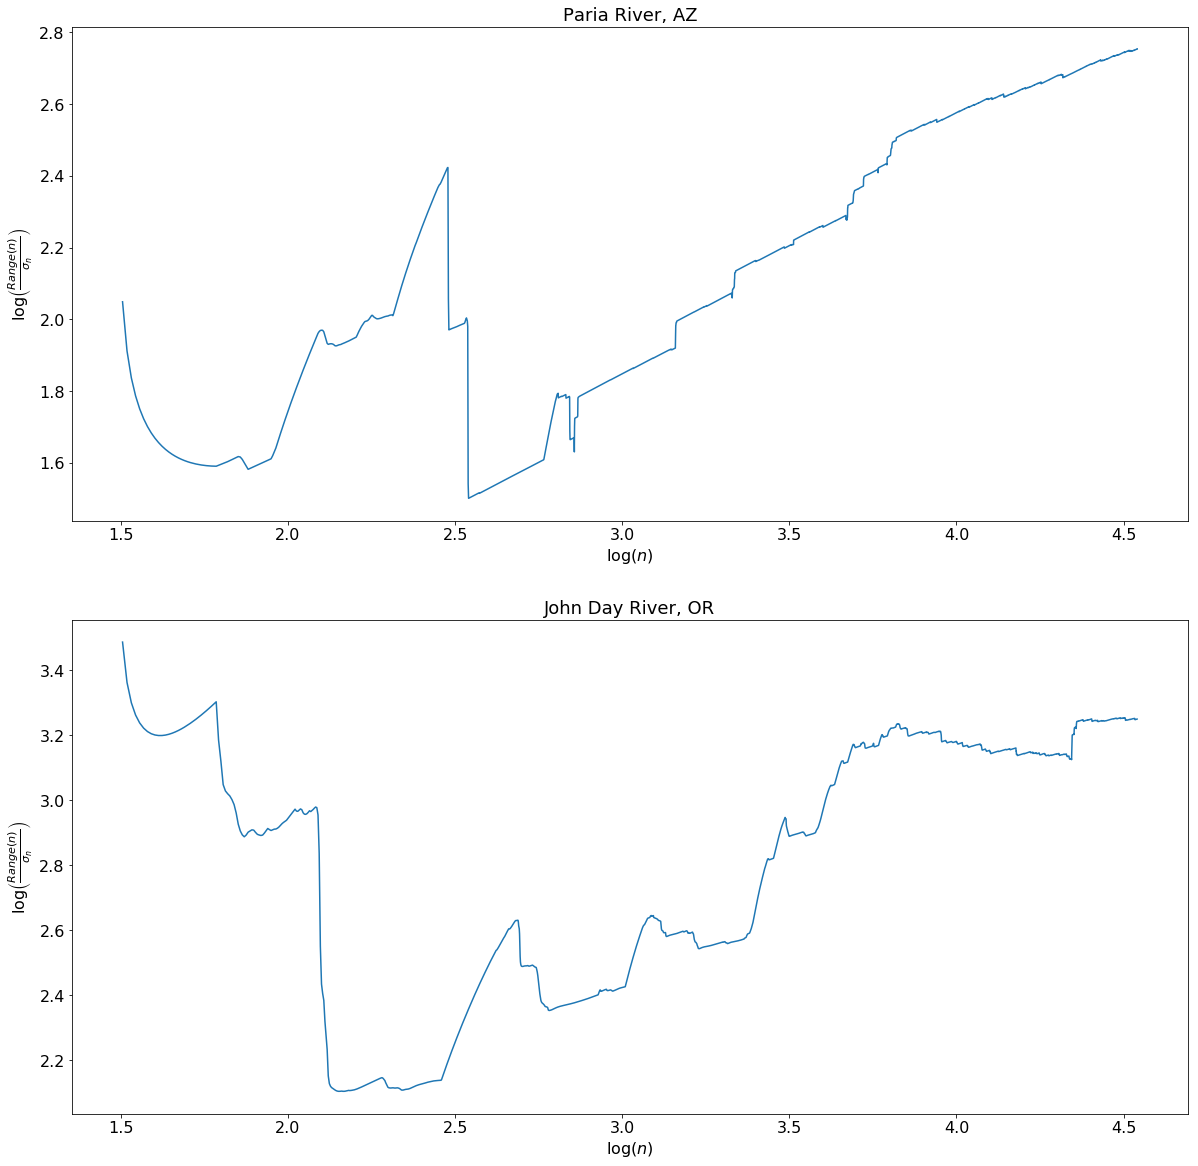

,Hurst exponent
"Paria River, AZ",0.513077
"John Day River, OR",0.383572


In [25]:
# plot in log-log, fit to get slope = hurst exponent
log_n = list(map(np.log10, range(32, len(az_range)+32)))
log_az = list(map(np.log10, az_range))
log_or = list(map(np.log10, or_range))

fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].plot(log_n, log_az)
ax[0].set(title='Paria River, AZ')
ax[1].plot(log_n, log_or)
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel=r'$\log(n)$', ylabel=r'$\log\left(\frac{Range(n)}{\sigma_n}\right)$')
plt.show()

h_az, b = np.polyfit(log_n, log_az, deg=1)
h_or, b = np.polyfit(log_n, log_or, deg=1)

df = pd.DataFrame([h_az, h_or], columns=['Hurst exponent'], index=['Paria River, AZ', 'John Day River, OR'])
df

### o. Find the mass exponents for the data sets and asses whether the records may be represented as a multifractal.

In [26]:
def chi(data, q, delta):
    # normalize integral of data
    integral = np.trapz(data)
    norm_data = [d/integral for d in data]
    # split into bins of size delta
    bindices = list(range(0, len(data), delta))
    # get areas
    areas = [np.trapz(data[xbin[0]:xbin[1]+1]) for xbin in zip(bindices, bindices[1:])]
    # add area in remainder bin
    if bindices[-1] < len(data):
        areas.append(np.trapz(data[bindices[-1]:]))
    # remove bins with no area
    areas = list(filter(lambda x: x>0, areas))
    # sum (area in each bin)**q
    total = sum([area**q for area in areas])
    return total

def tau(data, q):
    log_deltas = list(range(1, int(np.log2(len(data)))))
    # compute chi for various values of delta
    deltas = [2**n for n in log_deltas]
    xs = [chi(data, q, delta) for delta in deltas]
    log_chis = [np.log2(x) for x in xs]
    # fit log(delta) vs log(chi) to line
    m, b = np.polyfit(log_deltas, log_chis, deg=1)
    # slope is limit of log(chi)/log(delta) as delta -> 0 = tau(q)
    return m

def dimension(data, q):
    return tau(data, q)/(q-1)

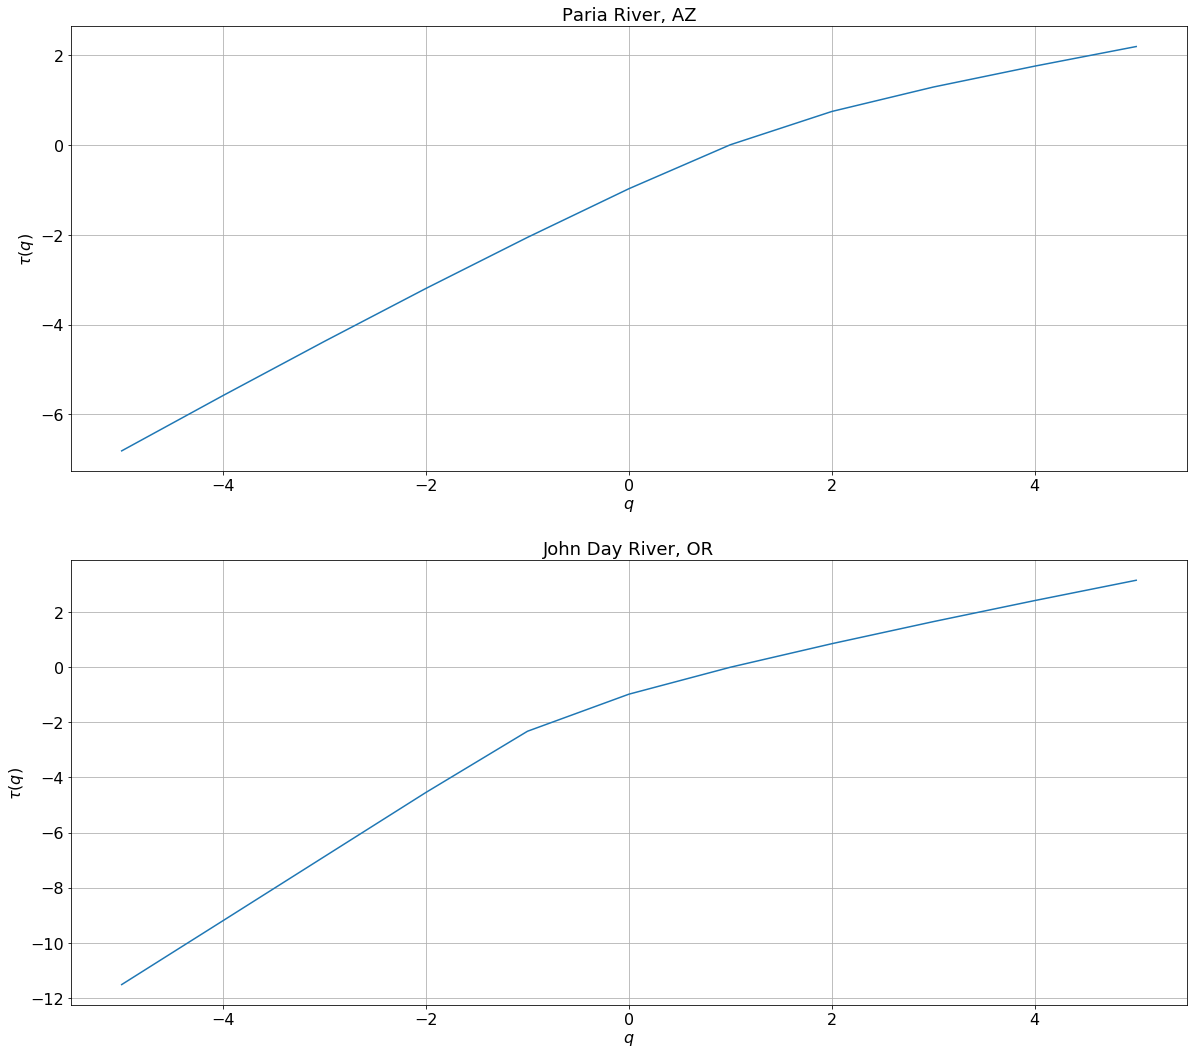

In [27]:
# plot the mass exponent function
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
for i, df in enumerate([df_az, df_or]):
    qs = list(range(-5, 6))
    taus = [tau(df.Flow, q) for q in qs]
    ax[i].plot(qs, taus)
    ax[i].set(xlabel=r'$q$', ylabel=r'$\tau(q)$')
    ax[i].grid()
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

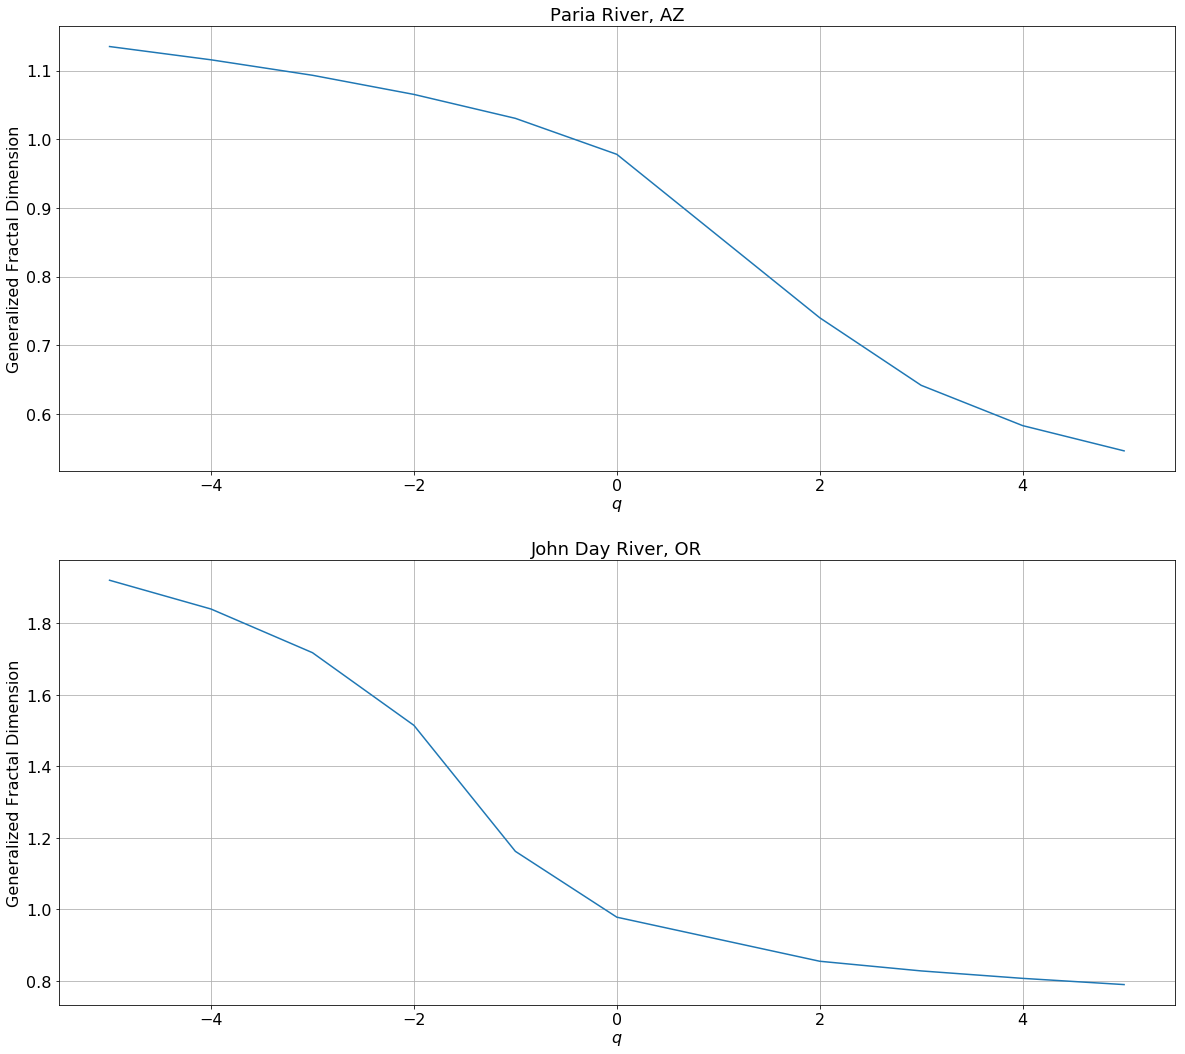

In [28]:
# plot the generalized dimension
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
for i, df in enumerate([df_az, df_or]):
    qs = list(filter(lambda x: x != 1, range(-5, 6)))
    dims = [dimension(df.Flow, q) for q in qs]
    ax[i].plot(qs, dims)
    ax[i].set(xlabel=r'$q$', ylabel='Generalized Fractal Dimension')
    ax[i].grid()
ax[0].set(title='Paria River, AZ')
ax[1].set(title='John Day River, OR')
plt.show()

Since the generalized fractal dimension changes considerably with q, we can conclude that the data are consistent with multifractals.